# このノートブックの概要

- 日付から祝日情報などの特徴量をつくる。
- 時系列的な特徴量はつくらない。
- TimeSeriesSplit で複数の XGBoost 予測器をつくりアンサンブル。

結果
- TimeSeriesSplit の k モデルのアンサンブル：
    - 4 folds & 1000 iter: Local CV 10.23 → Public LB 21.54
    - 10 folds & 1000 iter: Local CV 9.88 → Public LB 23.07
    - 10 folds & 10000 iter: Local CV 9.88 → Public LB 23.08
    - 10 folds & 1000 iter & eval_metric MAE: Local CV 9.64 → Public LB 23.04
- TimeSeriesSplit の k 番目のモデルのみ：
    - （新たに前後2日の祝日フラグ追加）10 folds & 1000 iter & eval_metric MAE: Local CV 6.76 → Public LB 7.22
- TimeSeriesSplit の k 番目のモデルで評価、フルサンプルで訓練しサブミット：
    - Local CV 6.77 → Public LB 7.08
    - FE seasonaliry: Local CV 9.69 → Public LB 6.89
    - FE country GDP: Local CV 6.80 → Public LB 7.89
    - FE seasonaliry & GDP: Local CV 9.51 → Public LB 7.54
    - FE seasonality & GDP & covid: Local CV 8.37 → Public LB 6.99

TODO
- done（feval_smape が使えないので）データセットを DMatrix 形式に書き換え。
- done（evals_result が使えないので）scikit learn API で書いているところを Learning API の train で書き換え。
- done 損失間数値の描画。
- done y_valid と y_pred の散布図。
- done OOF の評価コード書き換え。
- done oof と y と submission の分布。
- done ベストなイタレーションの決め方。
- done CV の設計。CV は TimeSeriesSplit の最後の分割だけで評価、サブミット時は全サンプルで学習、が筋では？
- done 外部データが使えるかどうか。たとえば各国の GDP データ。
- done 各国の新型コロナウイルス感染者数など。
- done train/test で分布差が大きいカラムは使わないほうがよいのかも。→ year 列を除いた
- year 列を除いた上で作業。
- コード整理。
- prophet の予測値を特徴量化。
- 訓練時の目的関数を SMAPE にする。
- ハイパラ調整。
- 外れ値への対応。

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv
/kaggle/input/gdp-20152019-finland-norway-and-sweden/GDP_data_2015_to_2021_for_TPS_Sept_2022.csv
/kaggle/input/gdp-20152019-finland-norway-and-sweden/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv
/kaggle/input/covid19-global-dataset/worldometer_coronavirus_daily_data.csv
/kaggle/input/covid19-global-dataset/worldometer_coronavirus_summary_data.csv


In [2]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [3]:
TRAIN_PATH = '../input/tabular-playground-series-sep-2022/train.csv'
TEST_PATH = '../input/tabular-playground-series-sep-2022/test.csv'
SUBMISSION_PATH = '../input/tabular-playground-series-sep-2022/sample_submission.csv'

GDP_PATH = '../input/gdp-20152019-finland-norway-and-sweden/GDP_data_2015_to_2021_for_TPS_Sept_2022.csv'
COVID_PATH = '../input/covid19-global-dataset/worldometer_coronavirus_daily_data.csv'

In [4]:
train_df = pd.read_csv(TRAIN_PATH, parse_dates=['date'])
test_df = pd.read_csv(TEST_PATH, parse_dates=['date'])

In [5]:
all_df = pd.concat([train_df, test_df])
all_df

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663.0
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615.0
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480.0
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710.0
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240.0
...,...,...,...,...,...,...
17515,87643,2021-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,NaN
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,NaN
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle Getting Started,NaN
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book,NaN


In [6]:
all_df['year'] = all_df['date'].dt.year
all_df['month'] = all_df['date'].dt.month
all_df['day'] = all_df['date'].dt.day
all_df['dayofweek'] = all_df['date'].dt.dayofweek
all_df['dayofmonth'] = all_df['date'].dt.days_in_month
all_df['dayofyear'] = all_df['date'].dt.dayofyear
all_df['weekday'] = all_df['date'].dt.weekday
all_df['weekofyear'] = all_df['date'].dt.isocalendar().week.astype(int)

# Seasonality features
for k in range(1, 20):
    all_df[f'sin{k}'] = np.sin(all_df['dayofyear'] / 365 * 2 * math.pi * k)
    all_df[f'cos{k}'] = np.cos(all_df['dayofyear'] / 365 * 2 * math.pi * k)

In [7]:
import holidays
from datetime import timedelta

# holidays flag
for country in ['BE', 'FR', 'DE', 'IT', 'PL', 'ES']:
    holidays_country = holidays.country_holidays(country)
    for d in [-2, -1, 0, +1, +2]:
        all_df[f'{country}_holidays_diff{d}'] = \
            (all_df['date'] + timedelta(days=d)).map(lambda x: x in holidays_country).astype(int)

In [8]:
# GDP
gdp_df = pd.read_csv(GDP_PATH)
gdp_df = pd.melt(gdp_df, id_vars='country', var_name='year', value_name='GDP')
gdp_df['year'] = gdp_df['year'].astype(int)

all_df = all_df.merge(gdp_df, how='left', on=['country', 'year'])

In [9]:
# covid
covid_df = pd.read_csv(COVID_PATH, parse_dates=['date'])
target_country_flag = covid_df['country'].isin(['Belguim', 'France', 'Germany', 'Italy', 'Poland', 'Spain'])
covid_df = covid_df[target_country_flag]

all_df = all_df.merge(covid_df, how='left', on=['country', 'date'])

In [10]:
all_df = all_df.fillna(0)
all_df.drop(columns=['num_sold', 'date', 'row_id', 'year'], inplace=True)
all_df

,country,store,product,month,day,dayofweek,dayofmonth,dayofyear,weekday,weekofyear,...,ES_holidays_diff-1,ES_holidays_diff0,ES_holidays_diff1,ES_holidays_diff2,GDP,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
0,Belgium,KaggleMart,Kaggle Advanced Techniques,1,1,6,31,1,6,52,...,0,0,1,0,502.76,0.0,0.0,0.0,0.0,0.0
1,Belgium,KaggleMart,Kaggle Getting Started,1,1,6,31,1,6,52,...,0,0,1,0,502.76,0.0,0.0,0.0,0.0,0.0
2,Belgium,KaggleMart,Kaggle Recipe Book,1,1,6,31,1,6,52,...,0,0,1,0,502.76,0.0,0.0,0.0,0.0,0.0
3,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,1,1,6,31,1,6,52,...,0,0,1,0,502.76,0.0,0.0,0.0,0.0,0.0
4,Belgium,KaggleRama,Kaggle Advanced Techniques,1,1,6,31,1,6,52,...,0,0,1,0,502.76,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87643,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,12,31,4,31,365,4,52,...,0,0,1,0,1430.00,6387937.0,93192.0,1234014.0,89447.0,42.0
87644,Spain,KaggleRama,Kaggle Advanced Techniques,12,31,4,31,365,4,52,...,0,0,1,0,1430.00,6387937.0,93192.0,1234014.0,89447.0,42.0
87645,Spain,KaggleRama,Kaggle Getting Started,12,31,4,31,365,4,52,...,0,0,1,0,1430.00,6387937.0,93192.0,1234014.0,89447.0,42.0
87646,Spain,KaggleRama,Kaggle Recipe Book,12,31,4,31,365,4,52,...,0,0,1,0,1430.00,6387937.0,93192.0,1234014.0,89447.0,42.0


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in ['country', 'product', 'store']:
    all_df[col] = le.fit_transform(all_df[col])
    
all_df

,country,store,product,month,day,dayofweek,dayofmonth,dayofyear,weekday,weekofyear,...,ES_holidays_diff-1,ES_holidays_diff0,ES_holidays_diff1,ES_holidays_diff2,GDP,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
0,0,0,0,1,1,6,31,1,6,52,...,0,0,1,0,502.76,0.0,0.0,0.0,0.0,0.0
1,0,0,1,1,1,6,31,1,6,52,...,0,0,1,0,502.76,0.0,0.0,0.0,0.0,0.0
2,0,0,2,1,1,6,31,1,6,52,...,0,0,1,0,502.76,0.0,0.0,0.0,0.0,0.0
3,0,0,3,1,1,6,31,1,6,52,...,0,0,1,0,502.76,0.0,0.0,0.0,0.0,0.0
4,0,1,0,1,1,6,31,1,6,52,...,0,0,1,0,502.76,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87643,5,0,3,12,31,4,31,365,4,52,...,0,0,1,0,1430.00,6387937.0,93192.0,1234014.0,89447.0,42.0
87644,5,1,0,12,31,4,31,365,4,52,...,0,0,1,0,1430.00,6387937.0,93192.0,1234014.0,89447.0,42.0
87645,5,1,1,12,31,4,31,365,4,52,...,0,0,1,0,1430.00,6387937.0,93192.0,1234014.0,89447.0,42.0
87646,5,1,2,12,31,4,31,365,4,52,...,0,0,1,0,1430.00,6387937.0,93192.0,1234014.0,89447.0,42.0


In [12]:
train = all_df[:len(train_df)]
test = all_df[len(train_df):]
y = train_df['num_sold']

In [13]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit


def smape(pred, obs):
    pred = np.array(pred)
    obs = np.array(obs)   
    return 100 * np.mean(2 * abs(pred-obs)/(abs(obs)+abs(pred)))


def feval_smape(pred, obs):
    pred = np.array(pred)
    obs = obs.get_label()
    return 'my_smape', 100 * np.mean(2 * abs(pred-obs)/(abs(obs)+abs(pred)))


params = {
    'objective': 'reg:squarederror',
    # 'eval_metric': 'mae',
    # 'max_depth': 6,
    'learning_rate': 0.03,
    'verbosity': 0
}

In [14]:
n_split = 10
kfold = TimeSeriesSplit(n_split)

test_pred = []
results = []
for fold_id, (train_id, valid_id) in enumerate(kfold.split(train)):
    
    print(f'------- fold: {fold_id + 1}-------')
    
    # if fold_id + 1 != n_split:
    #     continue
    
    x_train, y_train = train.iloc[train_id], y.iloc[train_id]
    x_valid, y_valid = train.iloc[valid_id], y.iloc[valid_id]
    
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    dtest  = xgb.DMatrix(test)
    
    result_dic = {}
    
    xgb_reg = xgb.train(
        params,
        dtrain,
        evals = [(dtrain, 'train'), (dvalid, 'eval')],
        evals_result=result_dic,
        custom_metric=feval_smape,
        num_boost_round=5000,
        early_stopping_rounds=200,
        verbose_eval=100
    )
    
    valid_pred = xgb_reg.predict(dvalid, ntree_limit=xgb_reg.best_ntree_limit)
    score_mape = mape(y_valid, valid_pred)
    score_smape = smape(y_valid, valid_pred)
    print(f'fold {fold_id+1}: OOF  MAPE {score_mape}')
    print(f'fold {fold_id+1}: OOF SMAPE {score_smape}')
    
    test_pred.append(xgb_reg.predict(dtest, ntree_limit=xgb_reg.best_ntree_limit))
    results.append(result_dic)

------- fold: 1-------
[0]	train-rmse:211.56105	train-my_smape:186.56638	eval-rmse:197.85332	eval-my_smape:185.81560
[100]	train-rmse:18.24157	train-my_smape:6.45119	eval-rmse:35.69339	eval-my_smape:14.71734
[200]	train-rmse:10.34356	train-my_smape:3.90461	eval-rmse:37.41156	eval-my_smape:13.65190
[300]	train-rmse:9.37713	train-my_smape:3.64710	eval-rmse:37.83339	eval-my_smape:13.42980
[400]	train-rmse:8.91970	train-my_smape:3.51920	eval-rmse:37.55522	eval-my_smape:13.34639
[500]	train-rmse:8.58688	train-my_smape:3.43353	eval-rmse:37.25259	eval-my_smape:13.36186
[600]	train-rmse:8.28606	train-my_smape:3.35299	eval-rmse:37.21851	eval-my_smape:13.39897
[628]	train-rmse:8.20224	train-my_smape:3.32966	eval-rmse:37.22639	eval-my_smape:13.40078
fold 1: OOF  MAPE 0.1413658919099638
fold 1: OOF SMAPE 13.343549797192985
------- fold: 2-------


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-rmse:204.94379	train-my_smape:186.48938	eval-rmse:221.53828	eval-my_smape:187.89862
[100]	train-rmse:19.28354	train-my_smape:7.18798	eval-rmse:47.70998	eval-my_smape:15.41147
[200]	train-rmse:11.50422	train-my_smape:4.42284	eval-rmse:40.72976	eval-my_smape:11.38827
[300]	train-rmse:10.02699	train-my_smape:4.03053	eval-rmse:40.53770	eval-my_smape:11.49163
[400]	train-rmse:9.52762	train-my_smape:3.89769	eval-rmse:40.54013	eval-my_smape:11.55724
[434]	train-rmse:9.41665	train-my_smape:3.87422	eval-rmse:40.54382	eval-my_smape:11.51769
fold 2: OOF  MAPE 0.10377786295741617
fold 2: OOF SMAPE 11.365060388741107
------- fold: 3-------


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-rmse:210.37100	train-my_smape:186.45805	eval-rmse:235.06195	eval-my_smape:187.59149
[100]	train-rmse:21.52730	train-my_smape:7.71147	eval-rmse:40.04927	eval-my_smape:12.32572
[200]	train-rmse:13.00817	train-my_smape:4.82009	eval-rmse:27.37195	eval-my_smape:8.06665
[300]	train-rmse:11.28033	train-my_smape:4.36382	eval-rmse:24.94187	eval-my_smape:7.64936
[400]	train-rmse:10.73731	train-my_smape:4.24251	eval-rmse:24.22695	eval-my_smape:7.48906
[500]	train-rmse:10.38862	train-my_smape:4.16129	eval-rmse:23.82820	eval-my_smape:7.41223
[600]	train-rmse:10.09326	train-my_smape:4.09112	eval-rmse:23.57113	eval-my_smape:7.35541
[700]	train-rmse:9.86800	train-my_smape:4.03214	eval-rmse:23.46106	eval-my_smape:7.32418
[800]	train-rmse:9.67190	train-my_smape:3.97002	eval-rmse:23.35380	eval-my_smape:7.29129
[900]	train-rmse:9.46218	train-my_smape:3.91496	eval-rmse:23.23558	eval-my_smape:7.26064
[1000]	train-rmse:9.26752	train-my_smape:3.84830	eval-rmse:23.14124	eval-my_smape:7.21719
[1100]	t

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


------- fold: 4-------
[0]	train-rmse:216.61817	train-my_smape:186.50631	eval-rmse:218.76044	eval-my_smape:187.17550
[100]	train-rmse:22.52318	train-my_smape:7.95114	eval-rmse:27.35682	eval-my_smape:9.88064
[200]	train-rmse:13.84740	train-my_smape:4.97893	eval-rmse:18.40047	eval-my_smape:6.27245
[300]	train-rmse:12.07864	train-my_smape:4.44994	eval-rmse:16.32070	eval-my_smape:5.61154
[400]	train-rmse:11.39781	train-my_smape:4.30012	eval-rmse:15.63671	eval-my_smape:5.40760
[500]	train-rmse:11.01283	train-my_smape:4.20994	eval-rmse:15.47991	eval-my_smape:5.37010
[600]	train-rmse:10.61865	train-my_smape:4.08220	eval-rmse:15.19343	eval-my_smape:5.28822
[700]	train-rmse:10.40171	train-my_smape:4.00666	eval-rmse:15.09495	eval-my_smape:5.26403
[800]	train-rmse:10.23511	train-my_smape:3.95505	eval-rmse:15.02970	eval-my_smape:5.23310
[900]	train-rmse:10.07680	train-my_smape:3.90746	eval-rmse:14.98938	eval-my_smape:5.22438
[1000]	train-rmse:9.91798	train-my_smape:3.86112	eval-rmse:14.96119	eval-

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


------- fold: 5-------
[0]	train-rmse:216.96786	train-my_smape:186.51605	eval-rmse:229.29932	eval-my_smape:187.36397
[100]	train-rmse:22.79496	train-my_smape:7.96324	eval-rmse:24.29112	eval-my_smape:7.81571
[200]	train-rmse:13.99326	train-my_smape:5.12751	eval-rmse:18.01452	eval-my_smape:5.92420
[300]	train-rmse:12.21313	train-my_smape:4.51607	eval-rmse:17.94204	eval-my_smape:5.99403
[389]	train-rmse:11.62809	train-my_smape:4.36217	eval-rmse:18.03095	eval-my_smape:6.03843
fold 5: OOF  MAPE 0.059795723131410954
fold 5: OOF SMAPE 5.903914374825268
------- fold: 6-------


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-rmse:219.02078	train-my_smape:186.52128	eval-rmse:216.60798	eval-my_smape:186.08899
[100]	train-rmse:23.08162	train-my_smape:8.02957	eval-rmse:22.19106	eval-my_smape:7.73331
[200]	train-rmse:14.16028	train-my_smape:5.09105	eval-rmse:16.00537	eval-my_smape:6.08847
[300]	train-rmse:12.60846	train-my_smape:4.58387	eval-rmse:15.68889	eval-my_smape:5.90876
[400]	train-rmse:12.00798	train-my_smape:4.43715	eval-rmse:15.91190	eval-my_smape:5.97760
[500]	train-rmse:11.67505	train-my_smape:4.36782	eval-rmse:16.02463	eval-my_smape:6.00525
[502]	train-rmse:11.67118	train-my_smape:4.36695	eval-rmse:16.02454	eval-my_smape:6.00533
fold 6: OOF  MAPE 0.06009171655488278
fold 6: OOF SMAPE 5.90231616235574
------- fold: 7-------


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-rmse:218.70542	train-my_smape:186.52625	eval-rmse:203.50139	eval-my_smape:186.64554
[100]	train-rmse:23.03551	train-my_smape:8.06166	eval-rmse:20.71472	eval-my_smape:8.12205
[200]	train-rmse:14.98317	train-my_smape:5.28540	eval-rmse:15.50120	eval-my_smape:5.94183
[300]	train-rmse:13.16071	train-my_smape:4.73001	eval-rmse:13.81893	eval-my_smape:5.27231
[400]	train-rmse:12.45903	train-my_smape:4.57174	eval-rmse:13.36112	eval-my_smape:5.12794
[500]	train-rmse:12.07075	train-my_smape:4.48110	eval-rmse:13.15148	eval-my_smape:5.06163
[600]	train-rmse:11.79487	train-my_smape:4.42168	eval-rmse:13.02023	eval-my_smape:5.03121
[700]	train-rmse:11.59454	train-my_smape:4.36925	eval-rmse:12.95302	eval-my_smape:5.01695
[800]	train-rmse:11.37001	train-my_smape:4.31538	eval-rmse:12.84740	eval-my_smape:5.00084
[900]	train-rmse:11.17612	train-my_smape:4.27057	eval-rmse:12.73864	eval-my_smape:4.98203
[1000]	train-rmse:10.98354	train-my_smape:4.21415	eval-rmse:12.63925	eval-my_smape:4.94808
[1100

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


------- fold: 8-------
[0]	train-rmse:216.86648	train-my_smape:186.52558	eval-rmse:251.48438	eval-my_smape:188.45012
[100]	train-rmse:22.91016	train-my_smape:8.05179	eval-rmse:79.12978	eval-my_smape:25.91324
[200]	train-rmse:14.36887	train-my_smape:5.16932	eval-rmse:75.18929	eval-my_smape:24.76527
[300]	train-rmse:12.92614	train-my_smape:4.67649	eval-rmse:75.42311	eval-my_smape:25.05744
[359]	train-rmse:12.43891	train-my_smape:4.57014	eval-rmse:75.59890	eval-my_smape:25.17465
fold 8: OOF  MAPE 0.20234137263182886
fold 8: OOF SMAPE 24.656302209163808
------- fold: 9-------


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-rmse:220.88284	train-my_smape:186.39818	eval-rmse:229.82604	eval-my_smape:186.41100
[100]	train-rmse:24.95522	train-my_smape:8.52998	eval-rmse:33.98408	eval-my_smape:12.12403
[200]	train-rmse:16.28602	train-my_smape:5.71644	eval-rmse:31.10670	eval-my_smape:11.41024
[300]	train-rmse:14.22048	train-my_smape:5.04055	eval-rmse:31.73252	eval-my_smape:11.89073
[339]	train-rmse:13.78029	train-my_smape:4.92608	eval-rmse:31.77143	eval-my_smape:11.92895
fold 9: OOF  MAPE 0.11348425663849179
fold 9: OOF SMAPE 11.379326318991549
------- fold: 10-------


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-rmse:221.83049	train-my_smape:186.45189	eval-rmse:253.94822	eval-my_smape:187.75331
[100]	train-rmse:25.91760	train-my_smape:8.82580	eval-rmse:48.00406	eval-my_smape:14.66729
[200]	train-rmse:17.17140	train-my_smape:6.00373	eval-rmse:36.64944	eval-my_smape:10.17571
[300]	train-rmse:14.77167	train-my_smape:5.15413	eval-rmse:33.93134	eval-my_smape:9.33857
[400]	train-rmse:13.74822	train-my_smape:4.90731	eval-rmse:33.14554	eval-my_smape:9.21942
[500]	train-rmse:13.14671	train-my_smape:4.76946	eval-rmse:32.48983	eval-my_smape:9.18459
[600]	train-rmse:12.70557	train-my_smape:4.66580	eval-rmse:31.64929	eval-my_smape:9.09211
[700]	train-rmse:12.34298	train-my_smape:4.57174	eval-rmse:31.22397	eval-my_smape:9.09720
[800]	train-rmse:12.12657	train-my_smape:4.51348	eval-rmse:31.01421	eval-my_smape:9.08446
[900]	train-rmse:11.93895	train-my_smape:4.45097	eval-rmse:31.08323	eval-my_smape:9.17391
[953]	train-rmse:11.85074	train-my_smape:4.42152	eval-rmse:31.12774	eval-my_smape:9.21870
fold

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


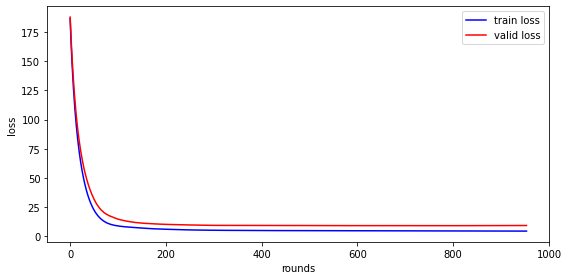

In [15]:
train_history = results[-1]['train']['my_smape']
valid_history = results[-1]['eval']['my_smape']

fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(8, 4))
sns.lineplot(x=range(len(train_history)), y=train_history, label='train loss', color='b', ax=ax)
sns.lineplot(x=range(len(valid_history)), y=valid_history, label='valid loss', color='r', ax=ax)
ax.set_ylabel('loss')
ax.set_xlabel('rounds')
plt.show()

In [16]:
# k model ensemble
y_pred = np.mean(test_pred, axis=0)

# last prediction
# y_pred = test_pred[-1]

# submit
sub = pd.read_csv(SUBMISSION_PATH)
sub['num_sold'] = y_pred
sub.to_csv('submission.csv', index=False)

display(pd.DataFrame(pd.Series(y.ravel()).describe()).T)
display(pd.DataFrame(pd.Series(y_pred.ravel()).describe()).T)

,count,mean,std,min,25%,50%,75%,max
0,70128.0,194.296986,126.893874,19.0,95.0,148.0,283.0,986.0


,count,mean,std,min,25%,50%,75%,max
0,17520.0,192.540253,123.697639,28.101482,95.407484,152.059761,281.067627,727.375793


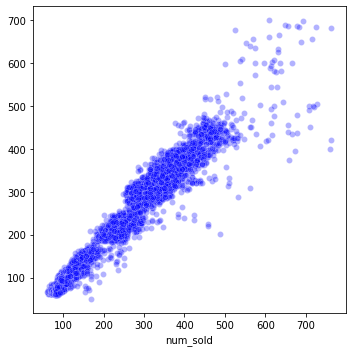

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(5, 5))
sns.scatterplot(x=y_valid, y=valid_pred, alpha=.3, color='b', ax=ax)
plt.show()

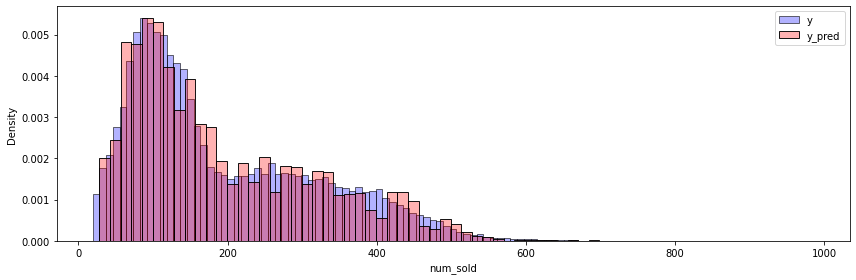

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(12, 4))
sns.histplot(y,      stat='density', label='y',      alpha=.3, color='b', ax=ax)
sns.histplot(y_pred, stat='density', label='y_pred', alpha=.3, color='r', ax=ax)
ax.legend()
plt.show()

## ハイパーパラメータをもとに再学習

In [19]:
best_ntree_limit = xgb_reg.best_ntree_limit
print(best_ntree_limit)

dtrain = xgb.DMatrix(train, label=y)
dtest  = xgb.DMatrix(test)

xgb_reg = xgb.train(
    params,
    dtrain,
    num_boost_round=best_ntree_limit,
    # obj=loss_smape,
    verbose_eval=True,
)

y_pred = xgb_reg.predict(dtest, ntree_limit=best_ntree_limit)

754


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


In [20]:
# 最後に作ったモデルのスコアをサブミットする場合
if False:
    sub = pd.read_csv(SUBMISSION_PATH)
    sub['num_sold'] = y_pred
    sub.to_csv('submission.csv', index=False)
    sub

In [21]:
display(pd.DataFrame(pd.Series(y.ravel()).describe()).T)
display(pd.DataFrame(pd.Series(y_pred.ravel()).describe()).T)

,count,mean,std,min,25%,50%,75%,max
0,70128.0,194.296986,126.893874,19.0,95.0,148.0,283.0,986.0


,count,mean,std,min,25%,50%,75%,max
0,17520.0,229.473495,130.882782,52.159878,117.657118,187.538689,344.319611,804.232483


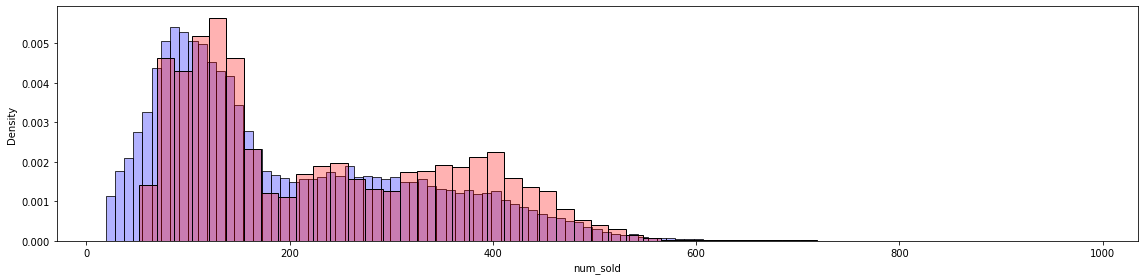

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(16, 4))
sns.histplot(y, stat='density', alpha=.3, color='b', ax=ax)
sns.histplot(y_pred, stat='density', alpha=.3, color='r', ax=ax)
plt.show()